In [ ]:
!pip install torch torchvision
!pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST Dataset



In [ ]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.2MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Vanilla Autoencoder

- **Purpose**: Compresses (encodes) input data into a lower-dimensional latent space and reconstructs (decodes) it back to the original form.  
- **Encoder**:
  - Flattens the 28x28 MNIST images into a 784-dimensional vector.  
  - Passes through three fully connected layers with decreasing dimensions (512 → 128 → 50).  
  - Uses **ReLU** activation for non-linearity.  
  - Outputs a **50-dimensional latent vector** (compressed representation).  

- **Decoder**:
  - Reconstructs the image from the 50-dimensional latent space.  
  - Mirrors the encoder structure (50 → 128 → 512 → 784).  
  - Uses a **Sigmoid** activation to ensure output pixel values are between **[0, 1]**.  

- **Forward Pass**:
  - Input is encoded to the latent space.  
  - Decodes the latent representation and reshapes it back to **(batch_size, 1, 28, 28)**.

In [ ]:
# Vanilla Autoencoder
class VanillaAutoencoder(nn.Module):
    def __init__(self):
        super(VanillaAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the image (28x28) to a 1D tensor (784)
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 50)  # Latent space
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(50, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Sigmoid()  # Ensure output values are between [0, 1]
        )

    def forward(self, x):
        # Encode
        latent = self.encoder(x)
        # Decode and reshape to (batch_size, 1, 28, 28)
        out = self.decoder(latent).view(-1, 1, 28, 28)
        return out

# Variational Autoencoder (VAE)

- **Purpose**:  
  - Extends the standard autoencoder by learning a **probabilistic latent space**.  
  - Generates new samples by sampling from the learned distribution.  

- **Encoder**:
  - Flattens the 28x28 input image into a **784-dimensional** vector.  
  - Passes through a **fully connected layer (512 units)** with **ReLU** activation.  
  - Outputs **mean (μ)** and **log variance (log(σ²))** for the latent space.  

- **Reparameterization Trick**:
  - Allows backpropagation through stochastic sampling.  
  - Computes the latent vector **z = μ + σ * ε**, where ε is sampled from a standard normal distribution.  

- **Decoder**:
  - Takes the latent vector **z** and reconstructs the input.  
  - Uses two fully connected layers to output an image reshaped to **(batch_size, 1, 28, 28)**.  
  - Applies a **sigmoid** function to keep pixel values between **[0, 1]**.  

- **Forward Pass**:
  1. **Encode**: Compute mean (μ) and log variance (log(σ²)).  
  2. **Reparameterize**: Sample from the latent space using the reparameterization trick.  
  3. **Decode**: Reconstruct the image from the sampled latent vector.  

- **Weight Initialization**:
  - Uses **Xavier Uniform** initialization for stable training.

In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc_mu = nn.Linear(512, self.latent_dim)
        self.fc_logvar = nn.Linear(512, self.latent_dim)

        # Decoder layers (Convolutional decoder)
        self.fc3 = nn.Linear(self.latent_dim, 512)
        self.fc4 = nn.Linear(512, 28 * 28)

        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def encode(self, x):
        x = x.view(-1, 28 * 28)
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# VAE Loss and Training Function

- **Loss Functions**:  
  - **MSELoss**: Measures reconstruction accuracy.  
  - **KL Divergence**: Regularizes the latent space to follow a standard normal distribution.  

- **VAE Loss**:  
  \[
  \text{Loss} = \text{Reconstruction Loss} + \text{KL Divergence}
  \]
  
- **Training Function**:  
  - Uses **Adam** optimizer (LR = `1e-3`).  
  - **VAE**: Uses combined VAE loss.  
  - **Autoencoder**: Uses **MSELoss** only.  
  - Updates weights via backpropagation and prints epoch-wise loss.

In [ ]:
mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss(reduction='sum')

# Improved VAE loss with β coefficient for KL divergence scaling
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = mse_loss(recon_x.view(x.size(0), -1), x.view(x.size(0), -1))  # Ensure matching shapes
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

def train_autoencoder(model, train_loader, epochs=50):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, _ in train_loader:
            images = images.to(device)
            optimizer.zero_grad()

            if isinstance(model, VAE):
                outputs, mu, logvar = model(images)
                loss = vae_loss(outputs, images, mu, logvar)  # VAE loss
            else:
                outputs = model(images)
                # Ensure consistent shape
                loss = mse_loss(outputs, images)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

# Model Instantiation and Training - VanillaAutoencoder

- **Initialize Model**: Create and move `VanillaAutoencoder` to the device.  
- **Train Model**: Use `train_autoencoder` to train on the MNIST dataset.  
- **Monitor Progress**: Print training loss per epoch.

In [ ]:
# Instantiate and train models
vanilla_autoencoder = VanillaAutoencoder().to(device)

print("Training Vanilla Autoencoder...")
train_autoencoder(vanilla_autoencoder, train_loader)

Training Vanilla Autoencoder...
Epoch 1, Loss: 0.04410190415233056
Epoch 2, Loss: 0.020117672072894284
Epoch 3, Loss: 0.01501156314651468
Epoch 4, Loss: 0.012256059084715111
Epoch 5, Loss: 0.010383813032336327
Epoch 6, Loss: 0.00923743214744177
Epoch 7, Loss: 0.008404382099427267
Epoch 8, Loss: 0.007779086156607246
Epoch 9, Loss: 0.007258283370521976
Epoch 10, Loss: 0.006877349172311742
Epoch 11, Loss: 0.006513296886643113
Epoch 12, Loss: 0.006224966291258775
Epoch 13, Loss: 0.005989354631023557
Epoch 14, Loss: 0.005763489352876761
Epoch 15, Loss: 0.005594177239103867
Epoch 16, Loss: 0.005405798891007201
Epoch 17, Loss: 0.005244058870605187
Epoch 18, Loss: 0.005110903358114744
Epoch 19, Loss: 0.004979689169659226
Epoch 20, Loss: 0.004864664488176166
Epoch 21, Loss: 0.004751797486493773
Epoch 22, Loss: 0.004667164188926853
Epoch 23, Loss: 0.004577958538357828
Epoch 24, Loss: 0.004507833329249801
Epoch 25, Loss: 0.004407103095493559
Epoch 26, Loss: 0.004342884602231671
Epoch 27, Loss: 0.

# Model Instantiation and Training - VAE

- **Initialize Model**: Create a `VAE` with `latent_dim=50` and move it to the device.  
- **Train Model**: Use `train_autoencoder` to train the VAE on the MNIST dataset.  
- **Monitor Progress**: Print training loss per epoch.

In [ ]:
vae = VAE(latent_dim=50).to(device)

print("Training VAE...")
train_autoencoder(vae, train_loader)

Training VAE...
Epoch 1, Loss: 4.843079627767555
Epoch 2, Loss: 0.08412803557000435
Epoch 3, Loss: 0.0733909156721538
Epoch 4, Loss: 0.07020348680616696
Epoch 5, Loss: 0.06888009447342297
Epoch 6, Loss: 0.06824227131760197
Epoch 7, Loss: 0.06790961387124397
Epoch 8, Loss: 0.06771228595900891
Epoch 9, Loss: 0.06761342450690422
Epoch 10, Loss: 0.06753863155968916
Epoch 11, Loss: 0.06750198160566247
Epoch 12, Loss: 0.06746528205523358
Epoch 13, Loss: 0.06743805717303554
Epoch 14, Loss: 0.06742068754235056
Epoch 15, Loss: 0.06741307736205648
Epoch 16, Loss: 0.06739698320245946
Epoch 17, Loss: 0.06738082713473326
Epoch 18, Loss: 0.06737872688119599
Epoch 19, Loss: 0.0673652381530957
Epoch 20, Loss: 0.06735733659791031
Epoch 21, Loss: 0.06735611919051548
Epoch 22, Loss: 0.0673518488640343
Epoch 23, Loss: 0.06734417366193556
Epoch 24, Loss: 0.06735107227206738
Epoch 25, Loss: 0.06734951220150949
Epoch 26, Loss: 0.06734441735469965
Epoch 27, Loss: 0.06734331295307257
Epoch 28, Loss: 0.06734649

- **Generate Images**:  
  - Creates `num_images` from random latent vectors.  
  - Uses `decoder` for **Vanilla Autoencoder** and `decode` for **VAE**.  

- **Plot Images**:  
  - Displays generated images in a grid with a title.  
  - Evaluate both models and generate images with matching `latent_dim`.  
  - Visualize outputs from **Vanilla Autoencoder** and **VAE**.

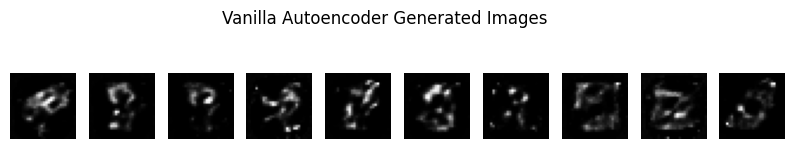

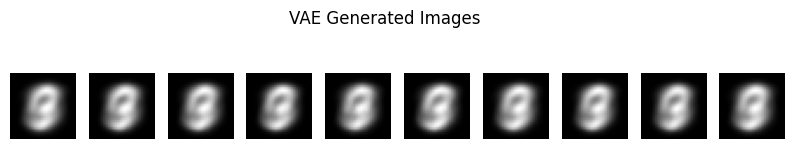

In [ ]:
# Generate images from random latent vectors
def generate_images(model, num_images=10, latent_dim=50):
    model.eval()  # Ensure model is in evaluation mode
    with torch.no_grad():
        # Generate random latent vectors (latent_dim should match the model's latent space size)
        random_latents = torch.randn(num_images, latent_dim).to(device)

        # If using Vanilla Autoencoder, directly call forward method
        if isinstance(model, VanillaAutoencoder):
            generated_images = model.decoder(random_latents).cpu().view(-1, 1, 28, 28)
        else:
            # For VAE, call the decode method directly
            generated_images = model.decode(random_latents).cpu().view(-1, 1, 28, 28)

        return generated_images

# Plot images in a grid
def plot_images(images, title):
    plt.figure(figsize=(10, 2))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Assuming you have vanilla_autoencoder and vae already defined and trained
vanilla_autoencoder.eval()  # Ensure model is in evaluation mode
vae.eval()  # Ensure model is in evaluation mode

# Generate images using both decoders
vanilla_images = generate_images(vanilla_autoencoder, latent_dim=50)  # Adjust latent_dim if necessary
vae_images = generate_images(vae, latent_dim=50)  # Same for VAE

# Plot the generated images from both models
plot_images(vanilla_images, "Vanilla Autoencoder Generated Images")
plot_images(vae_images, "VAE Generated Images")

- **Metric Calculation**:  
  - Uses **SSIM** (Structural Similarity) and **PSNR** (Peak Signal-to-Noise Ratio) to evaluate image quality.  
  - Applies a **3x3 window** for SSIM to capture finer details.  

- **Process**:  
  1. Extracts 10 original images from `train_loader`.  
  2. Computes SSIM and PSNR for both **Vanilla Autoencoder** and **VAE**.  
  3. Outputs the **average SSIM** and **PSNR** for both models.  

- **Output**:  
  Prints the average quality metrics for a quick model comparison.

- **SSIM (Structural Similarity Index Measure)**:  
  SSIM is a metric used to measure the similarity between two images. It takes into account changes in structural information, luminance, and texture. SSIM values range from **-1** to **1**, where **1** indicates perfect similarity, and values closer to **0** suggest less similarity. It is commonly used to assess the perceptual quality of images.

- **PSNR (Peak Signal-to-Noise Ratio)**:  
  PSNR is a metric that measures the quality of a reconstructed image compared to the original, specifically focusing on the difference in pixel values. It is measured in **decibels (dB)**, where higher values indicate better quality. A higher PSNR means there is less distortion between the original and generated images.

In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

def calculate_metrics(original, generated):
    # Ensure the images are the same shape and squeeze out any singleton dimensions
    original = original.squeeze()
    generated = generated.squeeze()

    # Use a smaller window size (3x3) for SSIM calculation
    ssim_value = ssim(original, generated, data_range=generated.max() - generated.min(), win_size=3)
    psnr_value = psnr(original, generated, data_range=generated.max() - generated.min())
    return ssim_value, psnr_value

# Calculate metrics for both autoencoders
original_images = next(iter(train_loader))[0][:10].cpu().numpy()
vanilla_metrics = [calculate_metrics(original_images[i], vanilla_images[i].cpu().numpy()) for i in range(10)]
vae_metrics = [calculate_metrics(original_images[i], vae_images[i].cpu().numpy()) for i in range(10)]

print("Vanilla Autoencoder - Avg SSIM:", np.mean([m[0] for m in vanilla_metrics]))
print("Vanilla Autoencoder - Avg PSNR:", np.mean([m[1] for m in vanilla_metrics]))
print("VAE - Avg SSIM:", np.mean([m[0] for m in vae_metrics]))
print("VAE - Avg PSNR:", np.mean([m[1] for m in vae_metrics]))

Vanilla Autoencoder - Avg SSIM: 0.4035713713104376
Vanilla Autoencoder - Avg PSNR: 8.785507203827946
VAE - Avg SSIM: 0.26924348936776443
VAE - Avg PSNR: 6.902846562806647


- **Vanilla Autoencoder**:  
  - Average SSIM: **0.40**  
  - Average PSNR: **8.79**  

- **VAE**:  
  - Average SSIM: **0.27**  
  - Average PSNR: **6.90**  

The **Vanilla Autoencoder** outperforms the **VAE** in both SSIM and PSNR, indicating better image quality.